In [1]:
# !pip install torchmetrics

In [2]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import sys

# Add project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

In [3]:
from models.EpidemiologyModels import EpidemiologyModelAllVariable, EpidemiologyOneOutput
from utils.Utilities import create_dataset, mar_dataset

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader,  TensorDataset
import torch.optim as optim

import random
from patsy import dmatrices
import statsmodels.api as sm

import matplotlib.gridspec as gridspec

import joblib

import seaborn as sns
sns.set_context('talk')
sns.set_style('white')


import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

torch.manual_seed(0)
np.random.seed(0)

In [5]:
import os
print(os.getcwd())


c:\Users\Yaknan\Documents\Academics\Rebekah's Thesis\code from Charles\lassa_fever_prediction_with_climate_data\models\lstm\LSTM_main_model


In [6]:
# Read Excel file
excel_file = '../../../data/raw/weeklydata.xlsx'
df = pd.read_excel(excel_file, engine='openpyxl')

In [7]:
# View data and column headings
print("Excel Data:")
print(df.head())
print("\nColumn Headings:")
print(df.columns)

Excel Data:
    state  year             datetime  epiweek  cases  tempmaxw  tempminw  \
0  Bauchi  2018  2018-01-07 00:00:00        1    1.0      29.5      10.8   
1  Bauchi  2018  2018-01-14 00:00:00        2    0.0      27.6      10.8   
2  Bauchi  2018  2018-01-21 00:00:00        3    0.0      30.5      11.7   
3  Bauchi  2018  2018-01-28 00:00:00        4    0.0      28.5      13.1   
4  Bauchi  2018  2018-02-04 00:00:00        5    0.0      34.6      15.6   

   tempw  humidityw  precipw  precipcovw  
0   19.0       36.1      0.0         0.0  
1   19.3       28.1      0.0         0.0  
2   21.2       24.8      0.0         0.0  
3   20.4       30.9      0.0         0.0  
4   24.8       23.8      0.0         0.0  

Column Headings:
Index(['state', 'year', 'datetime', 'epiweek', 'cases', 'tempmaxw', 'tempminw',
       'tempw', 'humidityw', 'precipw', 'precipcovw'],
      dtype='object')


In [8]:
assert df.isnull().sum().sum() == 0

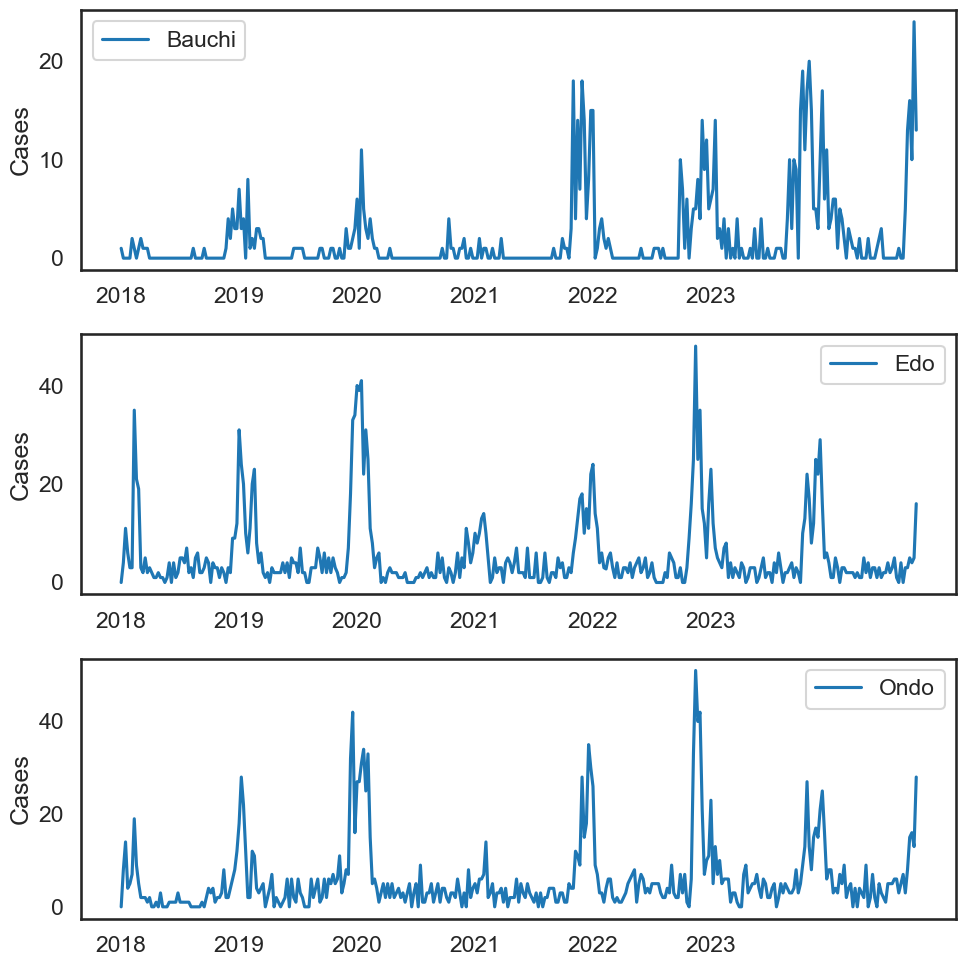

In [9]:
fig, axes = plt.subplots(3, 1, sharex=False, sharey=False, figsize=(10,10))
state = df[df['state'] == 'Bauchi']['cases'].copy()


axes[0].plot(state.values, label='Bauchi')
axes[0].set_ylabel("Cases")
axes[0].set_xticks([0, 54, 108, 162, 216, 270], ['2018', '2019', '2020', '2021', '2022', '2023'])
axes[0].legend()


state = df[df['state'] == 'Edo']['cases'].copy()
axes[1].plot(state.values, label='Edo')
axes[1].set_ylabel("Cases")
axes[1].set_xticks([0, 54, 108, 162, 216, 270], ['2018', '2019', '2020', '2021', '2022', '2023'])
axes[1].legend()


state = df[df['state'] == 'Ondo']['cases'].copy()
axes[2].plot(state.values, label='Ondo')
axes[2].set_ylabel("Cases")
axes[2].set_xticks([0, 54, 108, 162, 216, 270], ['2018', '2019', '2020', '2021', '2022', '2023'])
axes[2].legend()
fig.tight_layout()
fig.savefig("count_by_state.png", dpi=300, bbox_inches='tight')

In [10]:
feature_columns = ['tempmaxw', 'tempminw', 'tempw', 'humidityw', 'precipw', 'precipcovw', 'cases']
feature_scaler = MinMaxScaler(feature_range=(0, 1))

df[feature_columns] = feature_scaler.fit_transform(df[feature_columns].values)
df.head()


joblib.dump(feature_scaler, 'feature_scaler.bin', compress=True)

['feature_scaler.bin']

In [11]:
loopback = 4
X, Y = create_dataset(df, feature_columns,feature_columns, loopback)
print(X[2])
print(Y[1])
print(X.shape, Y.shape)

tensor([[0.4503, 0.1397, 0.2320, 0.1806, 0.0000, 0.0000, 0.0000],
        [0.3455, 0.2179, 0.1790, 0.2494, 0.0000, 0.0000, 0.0000],
        [0.6649, 0.3575, 0.4706, 0.1693, 0.0000, 0.0000, 0.0000],
        [0.7173, 0.4246, 0.6098, 0.1467, 0.0000, 0.0000, 0.0392]])
tensor([[0.4503, 0.1397, 0.2320, 0.1806, 0.0000, 0.0000, 0.0000],
        [0.3455, 0.2179, 0.1790, 0.2494, 0.0000, 0.0000, 0.0000],
        [0.6649, 0.3575, 0.4706, 0.1693, 0.0000, 0.0000, 0.0000],
        [0.7173, 0.4246, 0.6098, 0.1467, 0.0000, 0.0000, 0.0392]])
torch.Size([1091, 4, 7]) torch.Size([1091, 4, 7])


In [12]:
def train(df, train_val_years, feature_columns, lstm_hidden_size=100, n_lstm_layers=2,
          lookback = 6, n_epochs = 2000, bidirection=False, state_filter='Bauchi'):
    
    save_path = "./{}_model.pt".format(state_filter)

    best_value = torch.inf

    df = df[df['year'].isin(train_val_years)]    
    
    data = df[df['state']==state_filter].copy()
    data.sort_values(['year', 'epiweek'], inplace=True)
    data.sort_values(['year', 'epiweek'], inplace=True)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = EpidemiologyModelAllVariable(feature_dim=len(feature_columns), hidden_size=lstm_hidden_size, num_lstm_layers=n_lstm_layers, device=device)
    model = model.to(device)
    
    optimizer = optim.Adam(model.parameters())
    loss_fn_1 = nn.MSELoss()
    loss_fn_2 = nn.PoissonNLLLoss(log_input=False)

    data.index = data.datetime
    data.drop(columns=['state', 'year' ,'datetime', 'epiweek'], inplace=True)       

    X, Y = create_dataset(data, feature_columns, feature_columns, lookback)
    X, Y = X.to(device), Y.to(device)


    train_len = int(X.shape[0]*0.80)
    X_train, Y_train, X_val, Y_val = X[:train_len], Y[:train_len], X[train_len:], Y[train_len:]    
    
    
    loader = DataLoader(TensorDataset(X_train, Y_train), shuffle=False, batch_size=32)
    best_model = None

    train_log = []
    val_log = []
    print("Training Model for {} ....".format(state_filter))
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for X_batch, Y_batch in loader:            
            Y_pred  = model(X_batch)
            diff = Y_pred[1][:, 1:] - Y_pred[1][:, :-1] 
            loss = 0.3*loss_fn_1(Y_pred[0], Y_batch[:,:, :6]) + 0.4*loss_fn_2(Y_pred[1], Y_batch[:,:, -1]) +0.3*torch.mean(diff ** 2)    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss +=loss.item()            
        train_loss = train_loss/len(loader)
        train_log.append(train_loss)
        with torch.no_grad():
            model.eval()
            Y_pred_val = model(X_val)
            val_loss = loss_fn_1(Y_pred_val[0], Y_val[:,:, :6]) + loss_fn_2(Y_pred_val[1], Y_val[:,:, -1]).detach().cpu().numpy()           
            val_log.append(val_loss)            
            if (epoch+1) % 10 == 0:
                print("Epoch %d: train MSE + Poisson %.4f, MSE + Poisson %.4f" % (epoch, train_loss, val_loss))
                # if val_loss < best_value:                    
                #     print("Saving at Epoch %d" % (epoch))                    
                #     torch.save(model, save_path)                    
                #     best_value = val_loss
                #     best_model = model
    print("Training Model for {a} completed with Test MSE + Poisson {b:.2f}".format(a=state_filter, b=val_loss))
    fig= plt.figure(figsize=(20,10))
    plt.plot(np.array(train_log), c ='red', label="Train")
    plt.plot(np.array(val_log), c ='green', label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("MSE + Poisson Loss (On 0-1 Scaled Data)")
    plt.legend()

    plt.title('Training and Test Performance for {a} state.\n Test MSE + Poisson Loss (On 0-1 Scaled Data) {b:.2f}'.format(a=state_filter, b=val_loss), fontsize=20)
    plt.tight_layout()
    plt.savefig('{}_train_viz.png'.format(state_filter), bbox_inches='tight')
    torch.save(model, save_path)
    return model

In [13]:
# Define the years for training and testing data
train_val_years = [2019, 2020, 2022, 2023]  # Years for training data
test_years = [2018, 2019, 2020, 2022, 2023, 2024]  # test behavior of all years including 2023

lookback = 4

In [14]:
import sys, os

# Get the path to the models/ directory
models_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))

# Add it to sys.path if not already there
if models_path not in sys.path:
    sys.path.append(models_path)
print(models_path)

c:\Users\Yaknan\Documents\Academics\Rebekah's Thesis\code from Charles\lassa_fever_prediction_with_climate_data\models


In [15]:
from ipywidgets import interact_manual
@interact_manual(retrain_model = [False, True], state=["Bauchi", "Edo", "Ondo"], lookback = [4, 8, 1], lstm_hidden_size=[30, 40, 60]
                 , n_lstm_layers=[3, 2, 4, 1], bidirection_lstm=[False, True]
                 , n_epochs = [10, 1000, 1500, 2000])
def train_visualization(retrain_model,n_epochs, state, lookback, lstm_hidden_size, n_lstm_layers
                  ,bidirection_lstm):
    save_path = "./{}_model.pt".format(state)
    
    state_filter = state
    data=df
    if retrain_model:
        model = train(df, train_val_years, feature_columns, lstm_hidden_size=lstm_hidden_size, n_lstm_layers=n_lstm_layers, lookback = lookback,
                           n_epochs = n_epochs, bidirection=False, state_filter=state_filter)
    else:
        model = torch.load(save_path, weights_only=False)

    mse = metrics.mean_squared_error
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    data = df[df['state']==state_filter]
    data = data[data['year'].isin(test_years)].copy()
    data.sort_values(['year', 'epiweek'], inplace=True)
    data.sort_values(['year', 'epiweek'], inplace=True)   

    
    test_gp = data.groupby(['state'])
    s = state_filter
    state_data = test_gp.get_group(s)
    fig, axs = plt.subplots(2, 3, figsize=(20,10))
    fig_future, axs_future = plt.subplots(1, 2, figsize=(20,10))
    for j, ys in enumerate(test_years):
        state_data_year = state_data[state_data['year']== ys]
        state_data_year.drop(columns=['state', 'year', 'datetime'], inplace=True)
        X_test, y_test = create_dataset(state_data_year, feature_columns, feature_columns, lookback)

        X_test, y_test = X_test.to(device), y_test.to(device)
        
        with torch.no_grad():
            model.eval()
            rl = - 21
            X_test = torch.roll(X_test, rl, 0)
            y_test = torch.roll(y_test, rl, 0)

            y_pred = model(X_test)
            y_pred = torch.cat((y_pred[0], torch.unsqueeze(y_pred[1], 2)), dim=2)
            y_pred_transformed = feature_scaler.inverse_transform(y_pred.numpy()[:, -1, :])
            y_test_transformed = feature_scaler.inverse_transform(y_test.numpy()[:, -1, :])
            err= mse(y_pred_transformed[:, -1], y_test_transformed[:, -1])

        #
       # plot
        axs[j//3, j%3].title.set_text(str(ys)+", MSE: %.3f"%(err))
        axs[j//3, j%3].plot(y_pred_transformed[:,-1], label='pred_y')
        axs[j//3, j%3].plot(y_test_transformed[:,-1], label='true_y')
        axs[j//3, j%3].legend(loc="upper right")
        axs[j//3, j%3].set_xticks([0, 12, 24, 37, 52], ['June', 'Sep', 'Dec', 'Mar', 'June'])
        axs[j//3, j%3].set_ylabel('Number of cases')

    ## predicting future years
    for f_year in range(2):            
        with torch.no_grad():
            #first plot the prediction for the last test year
            future_transform = feature_scaler.inverse_transform(y_pred.cpu()[:, -1, :].numpy())
            axs_future[f_year].title.set_text("Year "+str(ys+f_year+1) +" Cases")
            axs_future[f_year].plot(future_transform[:,-1], label='Cases')
            axs_future[f_year].legend()
            axs_future[f_year].set_xticks([0, 12, 24, 37, 52], ['June', 'Sep', 'Dec', 'Mar', 'June'])
            axs_future[f_year].set_ylabel("Cases")
            y_pred = model(y_pred)
            y_pred = torch.cat((y_pred[0], torch.unsqueeze(y_pred[1], 2)), dim=2)


    fig.suptitle('Predictions for {} state'.format(s), fontsize=20)
    fig.tight_layout()
    fig_future.suptitle('Future Predictions for {} state'.format(s), fontsize=20)
    fig.savefig('{}_predictions.png'.format(state), bbox_inches='tight')
    fig_future.tight_layout()
    fig_future.savefig('{}_future_predictions.png'.format(state), bbox_inches='tight')
    

interactive(children=(Dropdown(description='retrain_model', options=(False, True), value=False), Dropdown(desc…

In [16]:
from ipywidgets import interact
import shap

# class ModelWrapperLSTM(nn.Module):
#     def __init__(self, theModel, feature_transform):
#         super().__init__()
#         self.model = theModel
#         self.feature_transform =feature_transform 
#     def forward(self, X):
#         n1 = X.shape[0]
#         X = torch.stack([torch.from_numpy(X[i-4:i]).float() for i in range(4, X.shape[0])])
#         for i in range(n1 - X.shape[0]):
#             X = torch.concat((X[[i]], X))
#         Pred = self.model(X)[:,-1, :]        
#         Pred = feature_scaler.inverse_transform(Pred.detach().numpy())
#         return Pred[:, -1]

class ModelWrapperLSTM(nn.Module):
    def __init__(self, theModel, feature_transform):
        super().__init__()
        self.model = theModel
        self.feature_transform = feature_transform  # assumed to be a scaler like MinMaxScaler

    def forward(self, X):
        n1 = X.shape[0]
        X = torch.stack([torch.from_numpy(X[i - 4:i]).float() for i in range(4, X.shape[0])])

        # Repeat padding to maintain input length
        for i in range(n1 - X.shape[0]):
            X = torch.cat((X[[i]], X))

        # ✅ Fix: unpack model output if it's a tuple
        output = self.model(X)
        if isinstance(output, tuple):
            output = output[0]  # take only the LSTM output

        Pred = output[:, -1, :]  # last timestep output

        Pred = self.feature_transform.inverse_transform(Pred.detach().numpy())
        return Pred[:, -1]


In [ ]:
@interact_manual(state=["Bauchi", "Edo", "Ondo"], year = [2018, 2019, 2020, 2021, 2022, 2023], lookback = [4, 8, 1], Num_Instances = [200, 400, 600, 800, 1200])
def explain_by_permutation(state, year, Num_Instances):
    data = df[df['state']==state].copy()
    test_data = data[data['year'].isin([year])].copy()
    test_data.sort_values(['year', 'epiweek'], inplace=True)    
    test_data = test_data.reset_index()
    test_data.drop(columns=['state', 'year', 'datetime', 'index', 'epiweek'], inplace=True)
    
    save_path = "./{}_model.pt".format(state)
    model = torch.load(save_path, weights_only=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    model = ModelWrapperLSTM(model, feature_columns)
    
    def custom_masker(mask, x):
        # in this simple example we just zero out the features we are masking
        d =(x*mask).reshape(1, len(x)) 
        return d
    
    explainer = shap.PermutationExplainer(model, custom_masker)    
    shap_values = explainer(test_data[feature_columns][:Num_Instances])
    fig = plt.figure(figsize=(20,15))
    plt.subplot(211, frameon=True)
    shap.plots.violin(shap_values,show=False)
    plt.subplot(212, frameon=True)
    shap.plots.bar(shap_values, order=shap_values.abs.mean(0),  show=False)
    plt.subplots_adjust(bottom=0.1, right=1.2, top=1.5)
    plt.show()

interactive(children=(Dropdown(description='state', options=('Bauchi', 'Edo', 'Ondo'), value='Bauchi'), Dropdo…

interactive(children=(Dropdown(description='state', options=('Bauchi', 'Edo', 'Ondo'), value='Bauchi'), Dropdo…

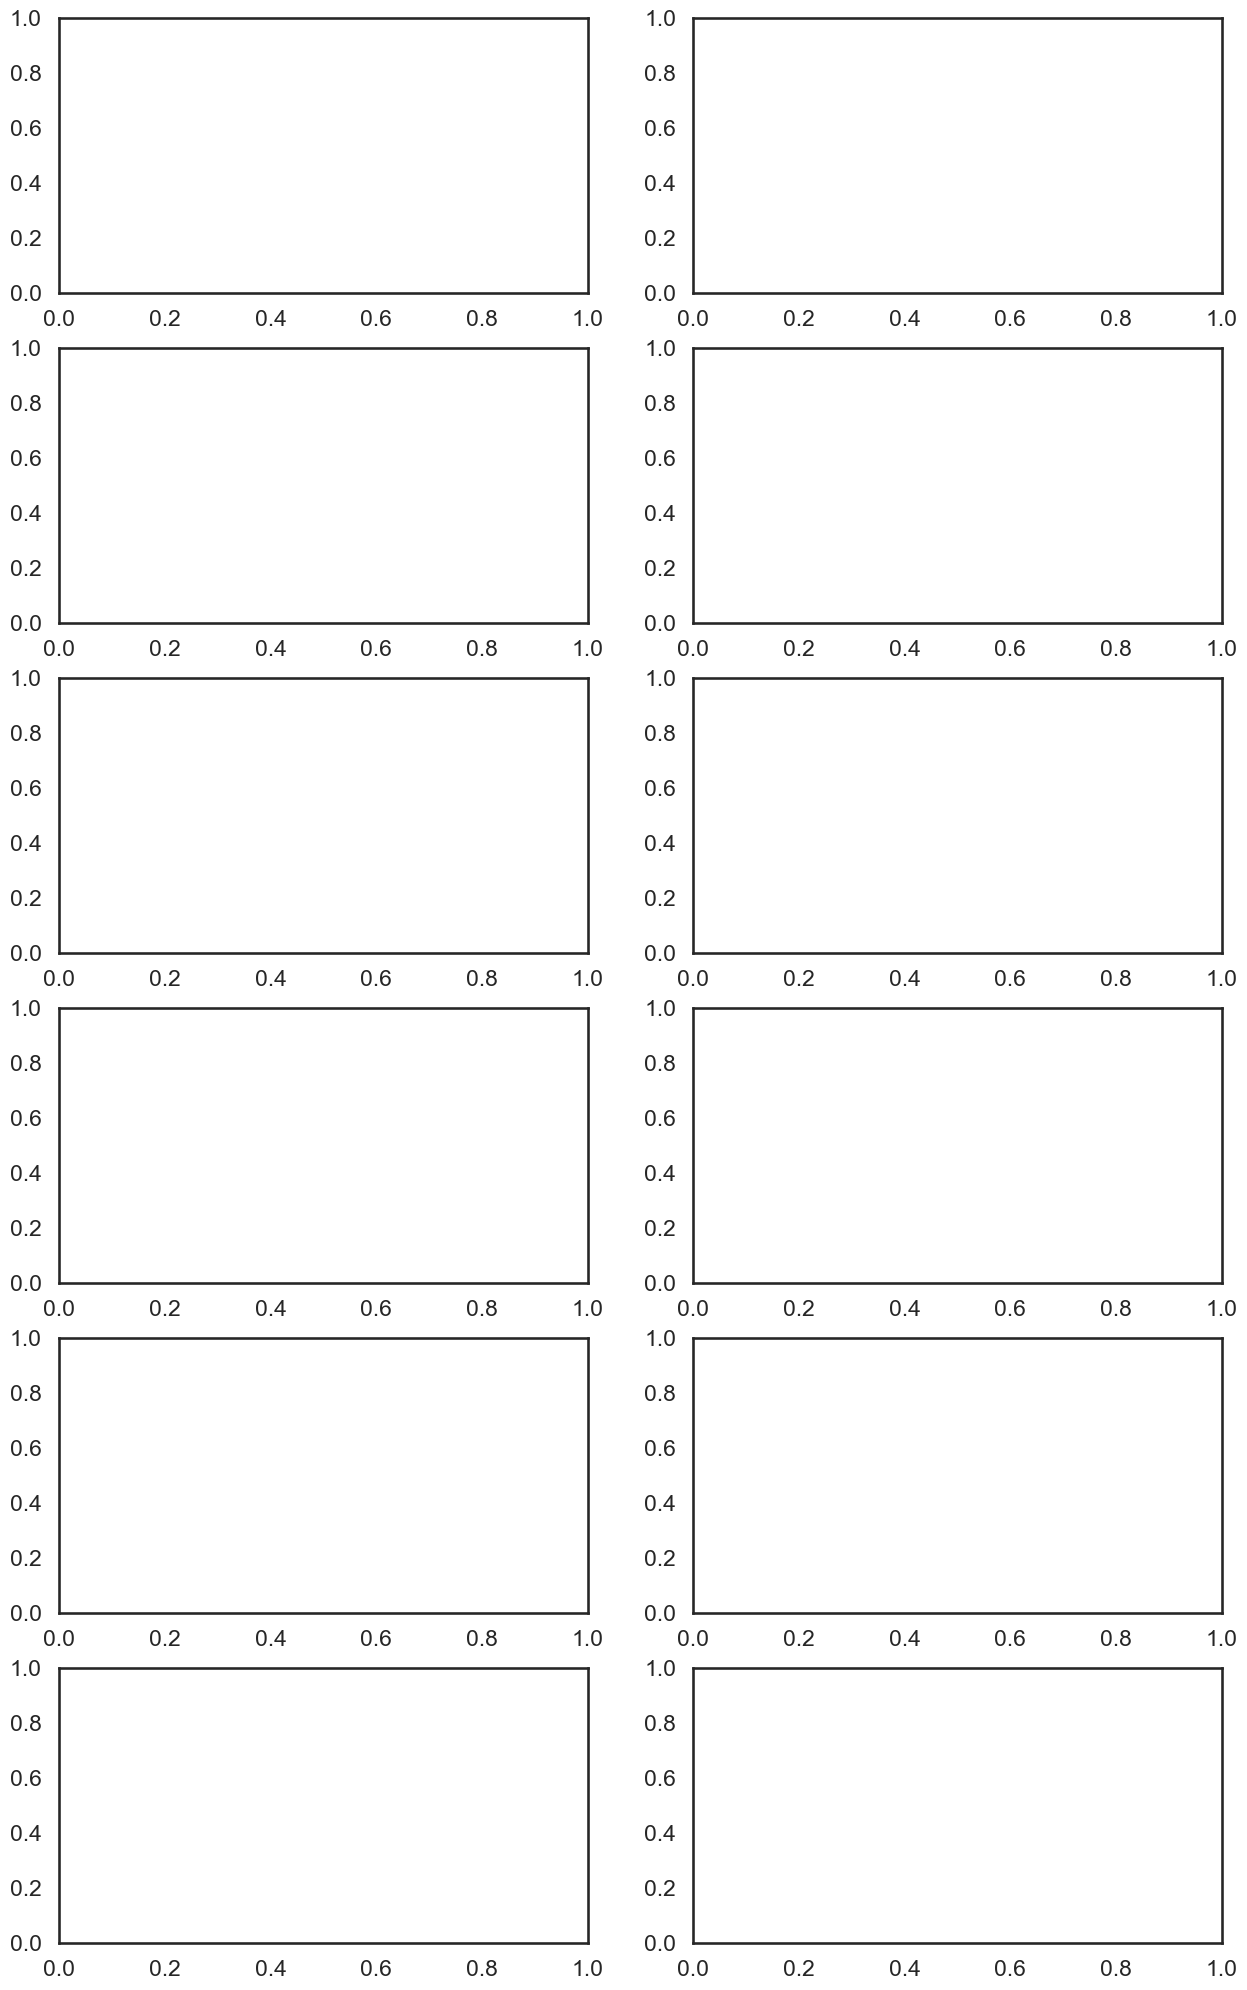

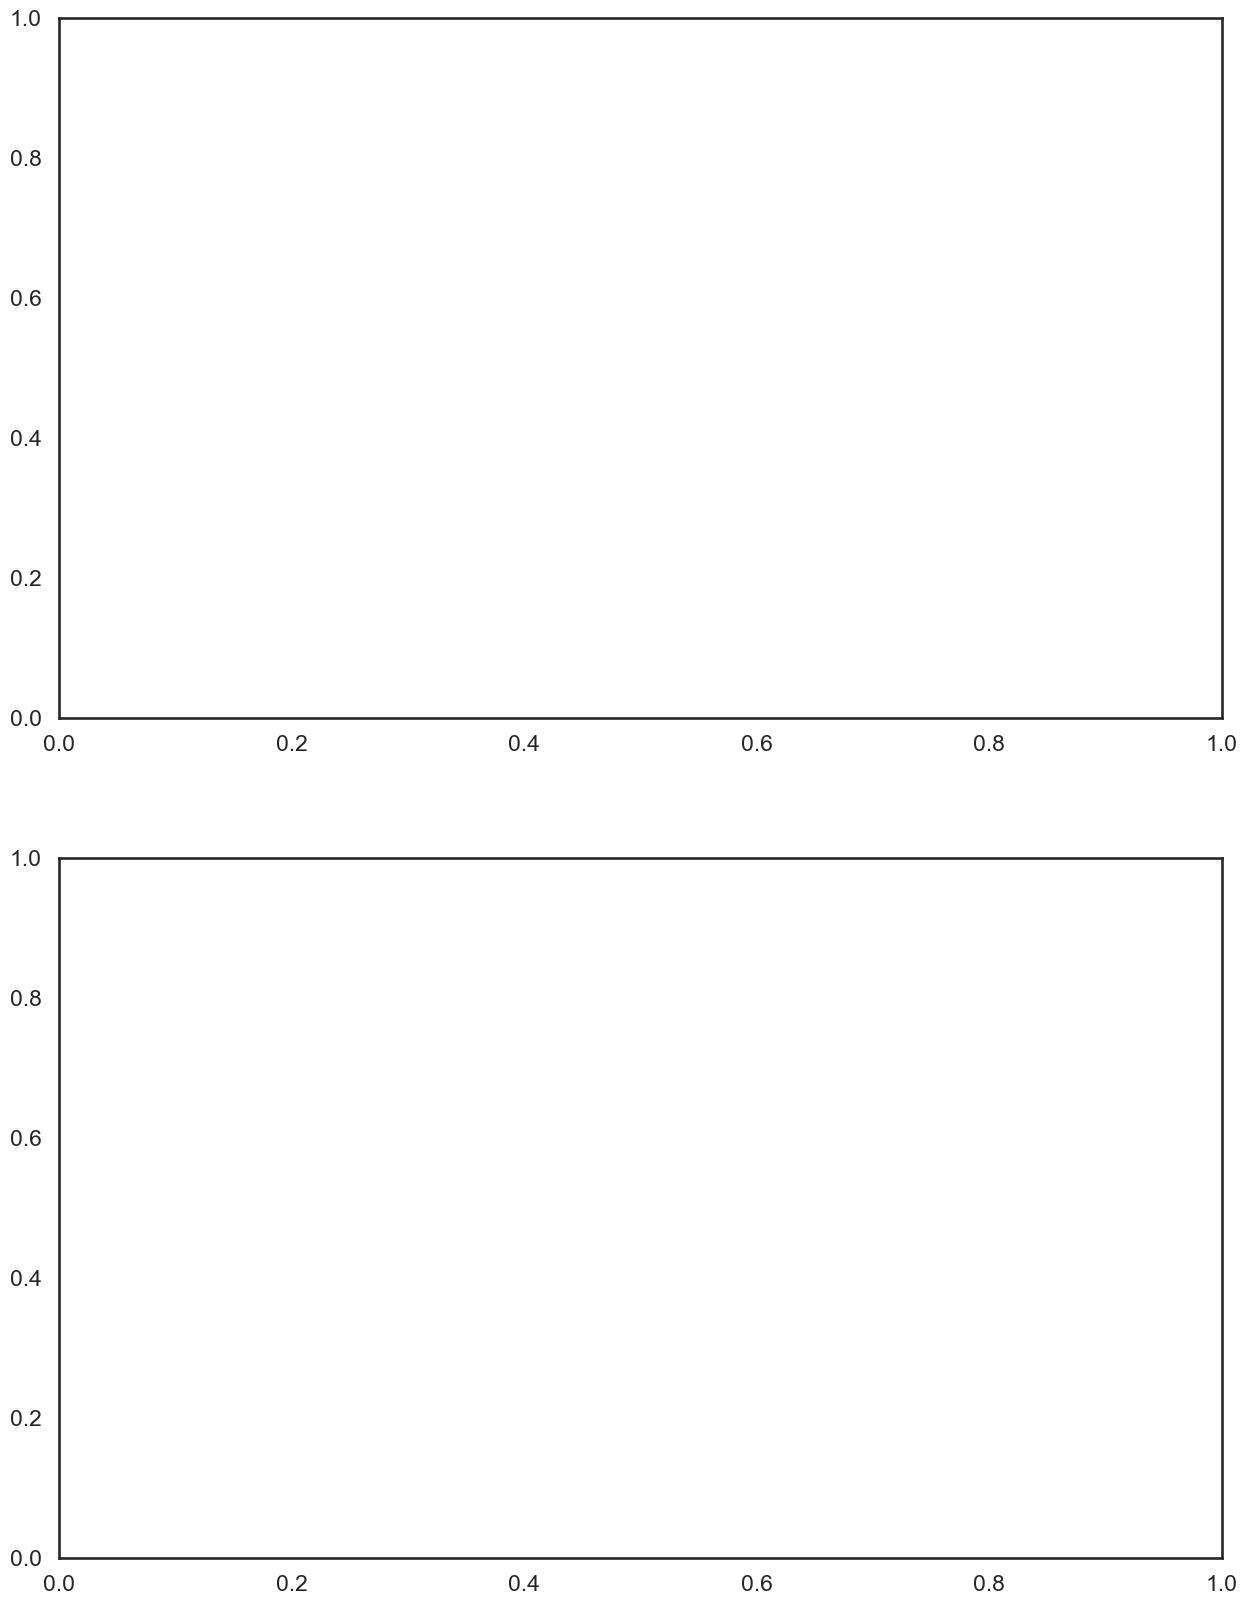

In [18]:
from ipywidgets import interact_manual
@interact_manual(state=["Bauchi", "Edo", "Ondo"]
          , addition_viz = {'Max Weekly Temp':('Max Weekly Temp', -7)
                            , 'Min Weekly Temp':('Min Weekly Temp',-6), 'Weekly of Temp':('Weekly Temp', -5)
                            , 'Weekly Humidity': ('Weekly Humidity', -4), 'Weekly Precipitation':('precipw', -3)
                            , 'Weekly Precipcovw': ('Weekly Precipcovw', -2)
                            }, lookback = [4, 8, 1])
def visualization_compare_all(state, addition_viz, lookback):
    save_path = "./{}_model.pt".format(state)
    
    state_filter = state
    data=df
    model = torch.load(save_path, weights_only=False)
    
    mae = metrics.mean_squared_error
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    data = df[df['state']==state_filter]
    data = data[data['year'].isin(test_years)].copy()
    data.sort_values(['year', 'epiweek'], inplace=True)
    data.sort_values(['year', 'epiweek'], inplace=True)   

    
    test_gp = data.groupby(['state'])
    s = state_filter
    state_data = test_gp.get_group(s)
    fig_cases_addviz, axs_cases_addviz = plt.subplots(6, 2, figsize=(15,25))
  
    fig_future, axs_future = plt.subplots(2,1, figsize=(15,20))
    
    for j, ys in enumerate(test_years):
        state_data_year = state_data[state_data['year']== ys]
        state_data_year.drop(columns=['state', 'year', 'datetime'], inplace=True)
        X_test, y_test = create_dataset(state_data_year, feature_columns, loopback)
        X_test, y_test = X_test.to(device), y_test.to(device)

        with torch.no_grad():
            model.eval()
            y_pred = model(X_test)                        
            y_pred_transform = feature_scaler.inverse_transform(y_pred.cpu()[:, -1, :].numpy())
            y_test_transform = feature_scaler.inverse_transform(y_test.cpu()[:, -1, :].numpy())
            err= mae(y_pred_transform, y_test_transform)
        
        axs_cases_addviz[j, 0].title.set_text(str(ys)+" Cases. MAE = %.2f "%(err))
        axs_cases_addviz[j, 0].plot(y_pred_transform[:,-1], label='pred_y')
        axs_cases_addviz[j, 0].plot(y_test_transform[:,-1], label='true_y')
        axs_cases_addviz[j, 0].set_xlabel('Week Index')
        axs_cases_addviz[j, 0].set_ylabel('Number of cases')
        axs_cases_addviz[j, 0].legend()
        
        axs_cases_addviz[j, 1].title.set_text(str(ys)+" {1}. MAE = {0:.2f}".format(err, addition_viz[0]))
        axs_cases_addviz[j, 1].plot(y_pred_transform[:,addition_viz[1]], label='pred_y')
        axs_cases_addviz[j, 1].plot(y_test_transform[:,addition_viz[1]], label='true_y')            
        axs_cases_addviz[j, 1].set_xlabel('Week Index')
        axs_cases_addviz[j, 1].set_ylabel(addition_viz[0])
        axs_cases_addviz[j, 1].legend()          

        ## predicting future years
    for f_year in range(2):            
        with torch.no_grad():
            #first plot the prediction for the last test year
            future_transform = feature_scaler.inverse_transform(y_pred.cpu()[:, -1, :].numpy())
            # axs_future[f_year].title.set_text("Year "+str(ys+f_year+1) +" Cases Vs {}".format(addition_viz[0]))
            axs_future[f_year].title.set_text("Year "+str(ys+f_year+1) +" Cases")
            axs_future[f_year].plot(future_transform[:,-1], label='Cases')
            # axs_future[f_year].plot(future_transform[:,addition_viz[1]], label= addition_viz[0])
            axs_future[f_year].legend()
            axs_future[f_year].set_xlabel('Week Index')
            # axs_future[f_year].set_ylabel("Cases/"+addition_viz[0])
            axs_future[f_year].set_ylabel("Cases")
            y_pred = model(y_pred)
    
    fig_cases_addviz.suptitle('Predictions for {} state'.format(s), fontsize=20)
    fig_future.suptitle('Future Predictions for {} state'.format(s), fontsize=20)
    
    fig_cases_addviz.tight_layout()
    fig_future.tight_layout()        
    plt.tight_layout()
    
    fig_cases_addviz.savefig('{}_{}_predict_compare_all_years.svg'.format(state, addition_viz[0]), bbox_inches='tight')
    fig_future.savefig('{}_future_prediction.svg'.format(state), bbox_inches='tight')